<a href="https://colab.research.google.com/github/rubanzasilva/flood_probability/blob/dev/s04e05_fastai_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install catboost
!pip install fastkaggle
!pip install optuna
!pip install optuna_distributed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.9 MB/s eta 0:00:00


In [ ]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp
import optuna
import optuna_distributed


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"3c109650146efc9c92fc9e8bfe70d487"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#chmod 600 /root/.kaggle/kaggle.json

In [ ]:
comp = 'playground-series-s4e5'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 28.0M/28.0M [00:01<00:00, 24.0MB/s]


In [ ]:
!ls

kaggle.json  playground-series-s4e5  playground-series-s4e5.zip  sample_data


In [ ]:
#set_seed(42)

In [ ]:
path = Path('playground-series-s4e5/')
path

Path('playground-series-s4e5')

In [ ]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')

In [ ]:
train_df

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,3,3,4,10,4,5,5,7,10,4,...,7,8,7,2,2,1,4,6,4,0.495
1117953,2,2,4,3,9,5,8,1,3,5,...,9,4,4,3,7,4,9,4,5,0.480
1117954,7,3,9,4,6,5,9,1,3,4,...,5,5,5,5,6,5,5,2,4,0.485


In [ ]:
train_df.shape,test_df.shape

((1117957, 21), (745305, 20))

In [ ]:
train_df.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [ ]:
#train_subset.hist(figsize=(20,15));

Using Subset

In [ ]:
train_subset = train_df.iloc[:30000]
test_subset = test_df.iloc[:30000]

In [ ]:
cont_names,cat_names = cont_cat_split(train_subset, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))
to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_subset)

SuggestedLRs(slide=0.013182567432522774, valley=0.0010000000474974513)

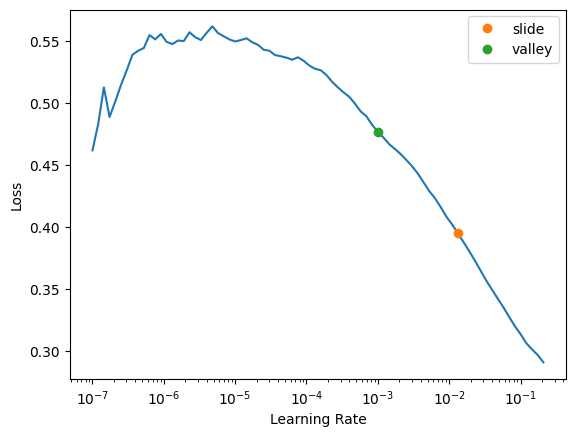

In [ ]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit_one_cycle(25,0.008)

In [ ]:
#learn.fit_one_cycle(5,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)


In [ ]:
r2_score(y_test,nn_preds_x)

0.740747148871282

Using random subset

Using a random subset results in better and faster training

In [ ]:
train_subset = train_df.sample(n=50000,replace=False)
test_subset = test_df.sample(n=30000,replace=False)

In [ ]:
cont_names,cat_names = cont_cat_split(train_subset, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))
to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_subset)

SuggestedLRs(slide=0.010964781977236271, valley=0.0020892962347716093)

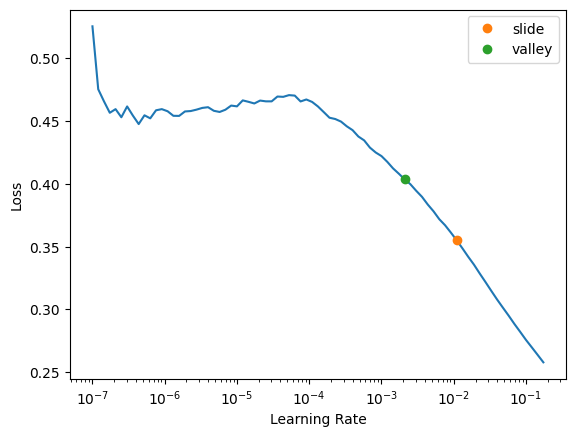

In [ ]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit_one_cycle(50,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

In [ ]:
r2_score(y_test,nn_preds_x)

0.7876894977427987

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.5687041412636994

In [ ]:
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
    }

    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    r2score = r2_score(y_test, rf_predictions)
    return r2score

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=100)
print(study_rf.best_params)

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=5,max_depth=4,min_samples_split=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.1798761514937982

In [ ]:
rf = RandomForestRegressor(26, min_samples_leaf=1,max_depth=2,min_samples_split=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.08417426348957979

In [ ]:
rf = RandomForestRegressor(26, min_samples_leaf=1)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.571364082610883

Using Full Dataset

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

SuggestedLRs(slide=0.009120108559727669, valley=0.0014454397605732083)

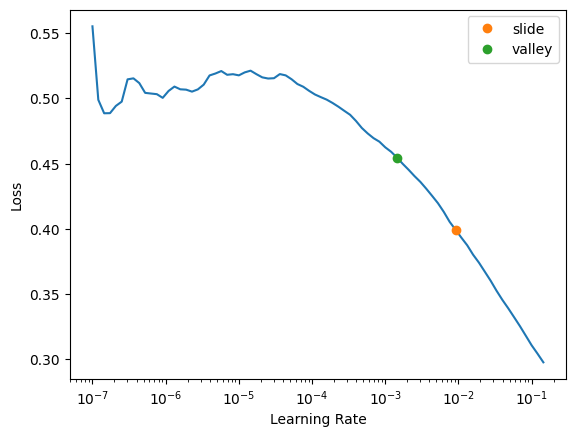

In [ ]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit_one_cycle(10,0.008)

epoch,train_loss,valid_loss,r2_score,time
0,0.000607,0.000688,0.735131,03:39
1,0.000525,0.000426,0.836143,03:36
2,0.000500,0.000417,0.839422,03:41
3,0.000466,0.000406,0.843895,03:55
4,0.000467,0.000409,0.842613,04:07
5,0.000512,0.000399,0.846630,04:15
6,0.000447,0.000385,0.851997,04:20
7,0.000436,0.000374,0.856081,04:16
8,0.000404,0.000369,0.858037,04:15
9,0.000395,0.000365,0.859605,04:16


In [ ]:
#learn.fit_one_cycle(5,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()


In [ ]:
r2_score(y_test,nn_preds_x)

0.8596047522511752

In [ ]:
learn.export('models/fp_colab_model.pkl')

In [ ]:
!ls

fp_colab_model.pkl  models		    playground-series-s4e5.zip
kaggle.json	    playground-series-s4e5  sample_data


In [ ]:
learn.load('fp_colab_model.pkl')

# Random Forest Baseline

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.6502577710952964

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=10)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

CPU times: user 7min 16s, sys: 1.05 s, total: 7min 17s
Wall time: 7min 27s


0.6037340079879046

In [ ]:
import optuna_distributed

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
    }

    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    r2score = r2_score(y_test, rf_predictions)
    return r2score

study_rf = optuna.create_study(direction='minimize')


# Convert the study to a distributed study
study_rf = optuna_distributed.from_study(study_rf)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_rf.optimize(objective_rf, n_trials=30, n_jobs=num_parallel_jobs)


print(study_rf.best_params)

# CatBoost

In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=1441, depth=10, learning_rate= 0.08, random_strength=27)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 16min 53s, sys: 4.82 s, total: 16min 58s
Wall time: 10min 6s


0.8484108713271834

In [ ]:
%%time
cat_model = CatBoostRegressor(iterations=1441, depth=10, learning_rate= 0.08, random_strength=27)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CPU times: user 16min 52s, sys: 5.05 s, total: 16min 57s
Wall time: 10min 10s


0.8484108713271834

In [ ]:
%%time

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score

# Create a study
study_catboost = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_catboost = optuna_distributed.from_study(study_catboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_catboost.optimize(objective_catboost, n_trials=100, n_jobs=num_parallel_jobs)

print(study_catboost.best_params)

In [ ]:
%%time
def objective(trial):
  model = CatBoostRegressor(
      iterations=trial.suggest_int("iterations", 1000, 3000),
      learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
      colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
      min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
      depth=trial.suggest_int("depth", 4, 15),
      l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
      verbose=False,
      random_state=27
      )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return np.sqrt(r2_score(y_test, y_pred))


 #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)



CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.9 µs


In [ ]:
 %%time
 optuna.logging.set_verbosity(optuna.logging.WARNING)

 sampler = optuna.samplers.TPESampler(seed=27)
 study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
 study.optimize(objective, n_trials=30)



In [ ]:
 print("Number of finished trials: ", len(study.trials))
 print("Best trial:")
 trial = study.best_trial
 print("  Value: ", trial.value)
 print("  Params: ")

 for key, value in trial.params.items():
     print(f"    {key}: {value}")
 print()

In [ ]:
!ls

catboost_info  models		       playground-series-s4e5.zip  submission.csv
kaggle.json    playground-series-s4e5  sample_data


In [ ]:
!rm submission.csv

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat_boost"

100% 13.2M/13.2M [00:01<00:00, 9.36MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!rm submission.csv

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip


# XGBoost

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, xgb_predictions)
    return r2score


study_xgboost = optuna.create_study(direction='minimize')


# Convert the study to a distributed study
study_xgboost = optuna_distributed.from_study(study_xgboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_xgboost.optimize(objective_xgboost, n_trials=100, n_jobs=num_parallel_jobs)


print(study_xgboost.best_params)

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.010075584926403267, subsample= 0.6945377090487166)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.44558567701831664

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 767, max_depth=13, learning_rate=0.22472048294428892, subsample= 0.8936985751131682)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.7720806105742355

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 767, max_depth=13, learning_rate=0.22472048294428892, subsample= 0.8936985751131682, min_child_weight=10, gamma=8.58031910185836e-07, colsample_bytree=0.04050040446078567, reg_alpha=0.16025160863896398, reg_lambda=6.875124639971543e-08, random_state=27)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.8459411327560431

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = xgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat_boost"

100% 13.2M/13.2M [00:01<00:00, 8.87MB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (12 hours from now).


# Light GBM

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504451


0.8353827730240946

In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')


# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)


print(study_lgbm.best_params)

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
mse = mean_absolute_error(y_test,cat_preds_x)
rmse = np.sqrt(mse)
rmse

0.12580042

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat boost"

100% 13.2M/13.2M [00:01<00:00, 9.79MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

# Model Ensemble

In [ ]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds.shape

torch.Size([223591])

In [ ]:
general_preds

tensor([0.3679, 0.5352, 0.5139,  ..., 0.5351, 0.4667, 0.4714])

In [ ]:
#use for submission
general_preds = (lgb_preds + xgb_preds + cat_preds + nn_preds_y)/4
general_preds

tensor([0.5748, 0.4557, 0.4546,  ..., 0.6199, 0.5490, 0.5149])

In [ ]:
r2_score(y_test,general_preds)

0.8526363872679361

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

catboost_info  models		       playground-series-s4e5.zip  submission.csv
kaggle.json    playground-series-s4e5  sample_data


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "general preds (lgb_preds + xgb_preds + cat_preds + nn_preds_y )"

100% 13.2M/13.2M [00:01<00:00, 9.30MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
if not iskaggle:
    push_notebook('rubanzasilva', 's04e05_fastai_exp1',
                  title='Flood Probability: s04e05_fastai_exp1',
                  file='s04e05_fastai_exp1.ipynb',
                  competition=comp, private=False, gpu=True)

NameError: name 'iskaggle' is not defined

In [ ]:
import os

# Check if the KAGGLE_USERNAME environment variable is set
iskaggle = 'KAGGLE_USERNAME' in os.environ

if not iskaggle:
    push_notebook('rubanzasilva', 's04e05_fastai_exp1',
                 title='Flood Probability: s04e05_fastai_exp1',
                 file='s04e05_fastai_exp1.ipynb',
                 competition=comp, private=False, gpu=True)


NameError: name 'push_notebook' is not defined

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.046018206875864616, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

KeyboardInterrupt: 

In [ ]:
r2_score(y_test,xgb_preds_x)

0.7817602531907657

In [ ]:
mse = mean_absolute_error(y_test, xgb_preds_x)
rmse = np.sqrt(mse)
rmse

0.13967574

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504491


0.8235475438046409

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!rm submission.csv

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip


In [ ]:
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability
0,1117957,0.575180
1,1117958,0.463337
2,1117959,0.450641
3,1117960,0.460754
4,1117961,0.461083
...,...,...
745300,1863257,0.484195
745301,1863258,0.457408
745302,1863259,0.634439
745303,1863260,0.566786


In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "lgb preds"

100% 13.2M/13.2M [00:00<00:00, 17.0MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = rf_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability,Rings
0,1117957,0.5,0.568910
1,1117958,0.5,0.454981
2,1117959,0.5,0.450971
3,1117960,0.5,0.471085
4,1117961,0.5,0.470031
...,...,...,...
745300,1863257,0.5,0.475079
745301,1863258,0.5,0.446771
745302,1863259,0.5,0.616611
745303,1863260,0.5,0.546384


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "rf_preds"

In [ ]:
!ls

In [ ]:
general_preds = (lgb_preds + xgb_preds + cat_preds)

In [ ]:
general_preds

tensor([1.7166, 1.3715, 1.3782,  ..., 1.8436, 1.6442, 1.5364])